## Prøvet at optimere for hvert k = 1-5

In [8]:
import pandas as pd
import numpy as np
import itertools

# -------------------------------
# Helper Functions
# -------------------------------
def low_pass(series, a1):
    """Causal EWMA filter."""
    return series.ewm(alpha=1 - a1, adjust=False).mean().values

def score(residuals, mask=None):
    """Compute RMSE; if mask is given, only over mask."""
    if mask is not None:
        residuals = residuals[mask]
    return np.sqrt(np.nanmean(residuals**2))

def rls_initialize(n_params, delta=1000):
    """Initialize θ=0 and P=δ·I."""
    return np.zeros(n_params), delta * np.eye(n_params)

def rls_update(theta, P, x_t, y_t, lam):
    """One RLS update step."""
    xcol = x_t.reshape(-1,1)
    denom = lam + (xcol.T @ P @ xcol).item()
    K = (P @ xcol) / denom
    err = y_t - (xcol.T @ theta.reshape(-1,1)).item()
    theta = theta + (K.flatten() * err)
    P     = (P - K @ xcol.T @ P) / lam
    return theta, P

# -------------------------------
# Online RLS Forecast Function
# -------------------------------
def online_rls_k(df, lam, a1, delta, k, extra_features=None):
    """
    Online k-step-ahead RLS med baseline-features
    [bias, y_{t-1}, precip_lp_{t+k-1}], plus extra shifted features.
    """
    D = df.copy()
    D['time'] = pd.to_datetime(D['time'])
    D.set_index('time', inplace=True)

    y_arr = D['KarupBro'].values
    prec  = D['precip_total_daily'].values
    n = len(D)
    m = k - 1

    # baseline precip prediction
    prec_pred = np.full(n, np.nan)
    prec_pred[:n-m] = prec[m:]
    prec_lp = low_pass(pd.Series(prec_pred, index=D.index), a1)

    # lag-1 inflow
    y_lag1 = np.full(n, np.nan)
    y_lag1[1:] = y_arr[:-1]

    # ekstra-features
    extra_preds = {}
    if extra_features:
        for f in extra_features:
            arr = D[f].values
            arr_pred = np.full(n, np.nan)
            arr_pred[:n-m] = arr[m:]
            if f == 'precip_total_daily':
                arr_pred = low_pass(pd.Series(arr_pred, index=D.index), a1)
            extra_preds[f] = arr_pred

    # init RLS
    n_params = 3 + (len(extra_features) if extra_features else 0)
    theta, P = rls_initialize(n_params, delta)

    # online predict + update
    yhat = np.full(n, np.nan)
    for t in range(m+1, n):
        x = [1.0, y_lag1[t], prec_lp[t]]
        if extra_features:
            for f in extra_features:
                x.append(extra_preds[f][t])
        x_t = np.array(x)
        yhat[t] = x_t @ theta            # predict
        if not np.isnan(y_arr[t]):       # update
            theta, P = rls_update(theta, P, x_t, y_arr[t], lam)

    return pd.Series(yhat, index=D.index)

# -------------------------------
# Forward Selection + Hyperparam Search
# -------------------------------
def forward_sel_with_hyper(df_reset, candidates,
                           lam_grid, a1_grid, delta,
                           max_features=None, k=1):
    """
    Forward selection med hyperparam-search,
    scorer RMSE på træningsdata. Returnerer:
      selected, best_lam, best_a1, best_rmse
    """
    D = df_reset.copy()
    D['time'] = pd.to_datetime(D['time'])
    D.set_index('time', inplace=True)
    y_orig = D['KarupBro']

    selected = []
    best_rmse = np.inf
    best_lam  = None
    best_a1   = None
    remaining = list(candidates)
    step = 0

    while remaining and (max_features is None or len(selected) < max_features):
        trial = []
        for f in remaining:
            for lam, a1 in itertools.product(lam_grid, a1_grid):
                feats = selected + [f]
                yhat = online_rls_k(df_reset, lam, a1, delta, k, extra_features=feats)
                rmse = score(yhat.values - y_orig.values)
                trial.append((rmse, f, lam, a1))
        trial.sort(key=lambda x: x[0])
        rmse_c, feat_c, lam_c, a1_c = trial[0]
        if rmse_c < best_rmse:
            selected.append(feat_c)
            best_rmse, best_lam, best_a1 = rmse_c, lam_c, a1_c
            remaining.remove(feat_c)
            step += 1
            print(f"[k={k}] Step {step}: tilføjet '{feat_c}' med λ={lam_c}, a₁={a1_c}, RMSE={best_rmse:.4f}")
        else:
            break

    return selected, best_lam, best_a1, best_rmse

# -------------------------------
# Main: Loop over k = 1–5
# -------------------------------
if __name__ == "__main__":
    # Load & clean data
    data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
    D = pd.read_csv(data_path)
    D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
    D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = np.nan
    D['temp_mean_daily'].interpolate(inplace=True)
    D['precip_total_daily'].fillna(0, inplace=True)

    df_full = D.reset_index(drop=True)
    df_full['time'] = pd.to_datetime(df_full['time'])
    df_full.set_index('time', inplace=True)
    df_full = df_full.reset_index()

    # Split
    n_test = 1023
    df_train = df_full.iloc[:-n_test].reset_index(drop=True)

    # Kandidat-features (ekskl. target og baseline precip)
    numeric = df_full.select_dtypes(include=[np.number]).columns.tolist()
    numeric.remove('KarupBro')
    numeric.remove('precip_total_daily')
    candidates = numeric

    # Hyperparam grids
    lam_grid = [0.9, 0.95, 0.99]
    a1_grid  = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    # Loop k = 1–5
    results = {}
    for k in range(1, 6):
        print(f"\n======== Kør forward selection for k = {k} ========\n")
        sel, lam_opt, a1_opt, rmse_opt = forward_sel_with_hyper(
            df_train, candidates, lam_grid, a1_grid,
            delta=1000, max_features=None, k=k
        )
        results[k] = {
            'features': sel,
            'lambda': lam_opt,
            'a1': a1_opt,
            'train_rmse': rmse_opt
        }
        print(f"\n[k={k}] Optimeret: features={sel}, λ={lam_opt}, a₁={a1_opt}, RMSE={rmse_opt:.4f}\n")

    # Opsummering
    print("****** Samlede resultater ******")
    for k, res in results.items():
        print(f"k={k}:  features={res['features']},  λ={res['lambda']},  a₁={res['a1']},  RMSE={res['train_rmse']:.4f}")


======== Kør forward selection for k = 1 ========

[k=1] Step 1: tilføjet 'radiation_global_daily' med λ=0.95, a₁=0.6, RMSE=583.3270
[k=1] Step 2: tilføjet 'precip_duration_daily' med λ=0.95, a₁=0.5, RMSE=567.6092

[k=1] Optimeret: features=['radiation_global_daily', 'precip_duration_daily'], λ=0.95, a₁=0.5, RMSE=567.6092


======== Kør forward selection for k = 2 ========

[k=2] Step 1: tilføjet 'precip_duration_daily' med λ=0.95, a₁=0.7, RMSE=537.8589
[k=2] Step 2: tilføjet 'temp_soil_mean_daily' med λ=0.95, a₁=0.7, RMSE=537.3418

[k=2] Optimeret: features=['precip_duration_daily', 'temp_soil_mean_daily'], λ=0.95, a₁=0.7, RMSE=537.3418


======== Kør forward selection for k = 3 ========

[k=3] Step 1: tilføjet 'precip_duration_daily' med λ=0.99, a₁=0.7, RMSE=566.9693
[k=3] Step 2: tilføjet 'temp_soil_mean_daily' med λ=0.99, a₁=0.8, RMSE=560.4691

[k=3] Optimeret: features=['precip_duration_daily', 'temp_soil_mean_daily'], λ=0.99, a₁=0.8, RMSE=560.4691


======== Kør forward selectio

## Rigtige

In [7]:
import pandas as pd
import numpy as np
import itertools

# -------------------------------
# Helper Functions
# -------------------------------
def low_pass(series, a1):
    """Causal EWMA filter."""
    return series.ewm(alpha=1 - a1, adjust=False).mean().values

def score(residuals, mask=None):
    """Compute RMSE; if mask is given, only over mask."""
    if mask is not None:
        residuals = residuals[mask]
    return np.sqrt(np.nanmean(residuals**2))

def rls_initialize(n_params, delta=1000):
    """Initialize θ=0 and P=δ·I."""
    return np.zeros(n_params), delta * np.eye(n_params)

def rls_update(theta, P, x_t, y_t, lam):
    """One RLS update step."""
    xcol = x_t.reshape(-1,1)
    denom = lam + (xcol.T @ P @ xcol).item()
    K = (P @ xcol) / denom
    err = y_t - (xcol.T @ theta.reshape(-1,1)).item()
    theta = theta + (K.flatten() * err)
    P     = (P - K @ xcol.T @ P) / lam
    return theta, P

# -------------------------------
# Online RLS Forecast Function
# -------------------------------
def online_rls_k(df, lam, a1, delta, k, extra_features=None):
    """
    Online k-step-ahead RLS with baseline features
    [bias, y_{t-1}, precip_lp_{t+k-1}], plus any extra_features (shifted by k-1).
    """
    D = df.copy()
    D['time'] = pd.to_datetime(D['time'])
    D.set_index('time', inplace=True)

    y_arr = D['KarupBro'].values
    prec  = D['precip_total_daily'].values
    n = len(D)
    m = k - 1

    # baseline precip prediction
    prec_pred = np.full(n, np.nan)
    prec_pred[:n-m] = prec[m:]
    prec_lp = low_pass(pd.Series(prec_pred, index=D.index), a1)

    # lag-1 inflow
    y_lag1 = np.full(n, np.nan)
    y_lag1[1:] = y_arr[:-1]

    # extra feature predictions
    extra_preds = {}
    if extra_features:
        for f in extra_features:
            arr = D[f].values
            arr_pred = np.full(n, np.nan)
            arr_pred[:n-m] = arr[m:]
            if f == 'precip_total_daily':
                arr_pred = low_pass(pd.Series(arr_pred, index=D.index), a1)
            extra_preds[f] = arr_pred

    # initialize RLS
    n_params = 3 + (len(extra_features) if extra_features else 0)
    theta, P = rls_initialize(n_params, delta)

    yhat = np.full(n, np.nan)
    for t in range(m+1, n):
        x = [1.0, y_lag1[t], prec_lp[t]]
        if extra_features:
            for f in extra_features:
                x.append(extra_preds[f][t])
        x_t = np.array(x)
        yhat[t] = x_t @ theta            # predict
        if not np.isnan(y_arr[t]):        # update
            theta, P = rls_update(theta, P, x_t, y_arr[t], lam)

    return pd.Series(yhat, index=D.index)

# -------------------------------
# Forward Selection + Hyperparam Search on Training Data
# -------------------------------
def forward_sel_with_hyper(df_reset, candidates,
                           lam_grid, a1_grid, delta,
                           max_features=None, k=1):
    """
    Forward selection with hyperparam search,
    scoring RMSE on all train points.
    Returns selected features, best λ, best a₁, best train RMSE.
    """
    D = df_reset.copy()
    D['time'] = pd.to_datetime(D['time'])
    D.set_index('time', inplace=True)
    y_orig = D['KarupBro']

    selected = []
    best_rmse = np.inf
    best_lam  = None
    best_a1   = None
    remaining = list(candidates)

    step = 0
    while remaining and (max_features is None or len(selected) < max_features):
        trial_results = []
        for f in remaining:
            for lam, a1 in itertools.product(lam_grid, a1_grid):
                feats = selected + [f]
                yhat = online_rls_k(df_reset, lam, a1, delta, k, extra_features=feats)
                rmse = score(yhat.values - y_orig.values)
                trial_results.append((rmse, f, lam, a1))
        trial_results.sort(key=lambda x: x[0])
        rmse_cand, feat_cand, lam_cand, a1_cand = trial_results[0]
        if rmse_cand < best_rmse:
            selected.append(feat_cand)
            best_rmse = rmse_cand
            best_lam   = lam_cand
            best_a1    = a1_cand
            remaining.remove(feat_cand)
            step += 1
            print(f"Step {step}: added '{feat_cand}' with λ={lam_cand}, a₁={a1_cand}, RMSE={best_rmse:.4f}")
        else:
            break

    return selected, best_lam, best_a1, best_rmse

# -------------------------------
# Main: Train/Test Split & Execution
# -------------------------------
if __name__ == "__main__":
    # Load & clean data
    data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
    D = pd.read_csv(data_path)
    D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
    D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = np.nan
    D['temp_mean_daily'].interpolate(inplace=True)
    D['precip_total_daily'].fillna(0, inplace=True)

    # Prepare full dataframe
    D['time'] = pd.to_datetime(D['time'])
    D.set_index('time', inplace=True)
    df_full = D.reset_index()

    # Split into train/test
    n_test = 1023
    df_train = df_full.iloc[:-n_test].reset_index(drop=True)
    df_test  = df_full.iloc[-n_test:].reset_index(drop=True)

    # Determine candidate features (exclude target and baseline precip)
    numeric = df_full.select_dtypes(include=[np.number]).columns.tolist()
    numeric.remove('KarupBro')
    numeric.remove('precip_total_daily')
    candidates = numeric

    # Hyperparameter grids
    lam_grid = [0.9, 0.95, 0.99]
    a1_grid  = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    # Forward selection + hyper tuning on TRAIN set
    selected, lam_opt, a1_opt, train_rmse = forward_sel_with_hyper(
        df_train, candidates, lam_grid, a1_grid, delta=1000, max_features=None, k=1
    )
    print("\nSelected features (train):", selected)
    print(f"Optimal λ={lam_opt}, a₁={a1_opt}, Train RMSE (all): {train_rmse:.4f}")

    # Compute train RMSE on last n_test points for fair comparison
    yhat_train = online_rls_k(df_train, lam_opt, a1_opt, delta=1000, k=1, extra_features=selected)
    train_times = df_train['time'].iloc[-n_test:]
    y_train = df_train['KarupBro'].iloc[-n_test:].values
    yhat_train_tail = yhat_train.loc[train_times].values
    train_rmse_tail = score(yhat_train_tail - y_train)
    print(f"Train RMSE over last {n_test} points: {train_rmse_tail:.4f}")

    # Online forecasting on FULL series with frozen model
    yhat_full = online_rls_k(df_full, lam_opt, a1_opt, delta=1000, k=1, extra_features=selected)
    # Extract test forecasts and compute test RMSE
    test_index = df_full['time'].iloc[-n_test:]
    y_test = df_full['KarupBro'].iloc[-n_test:].values
    yhat_test = yhat_full.loc[test_index].values
    test_rmse = score(yhat_test - y_test)
    print(f"Test RMSE (last {n_test}): {test_rmse:.4f}")

    # Compute test RMSE on top 10% extreme values
    thr_extreme = np.quantile(y_test, 0.9)
    mask_extreme = y_test >= thr_extreme
    test_rmse_ext = score(yhat_test - y_test, mask=mask_extreme)
    print(f"Test RMSE_extreme (top 10% of last {n_test}): {test_rmse_ext:.4f}")

Step 1: added 'radiation_global_daily' with λ=0.95, a₁=0.6, RMSE=583.3270
Step 2: added 'precip_duration_daily' with λ=0.95, a₁=0.5, RMSE=567.6092

Selected features (train): ['radiation_global_daily', 'precip_duration_daily']
Optimal λ=0.95, a₁=0.5, Train RMSE (all): 567.6092
Train RMSE over last 1023 points: 305.6559
Test RMSE (last 1023): 388.6450
Test RMSE_extreme (top 10% of last 1023): 749.9178


## Tester

Step 1: added 'radiation_global_daily' with λ=0.95, a₁=0.6, RMSE=583.3270
Step 2: added 'precip_duration_daily' with λ=0.95, a₁=0.5, RMSE=567.6092

Selected features (train): ['radiation_global_daily', 'precip_duration_daily']
Optimal λ=0.95, a₁=0.5, Train RMSE (all): 567.6092
Test RMSE (last 1023): 388.6450


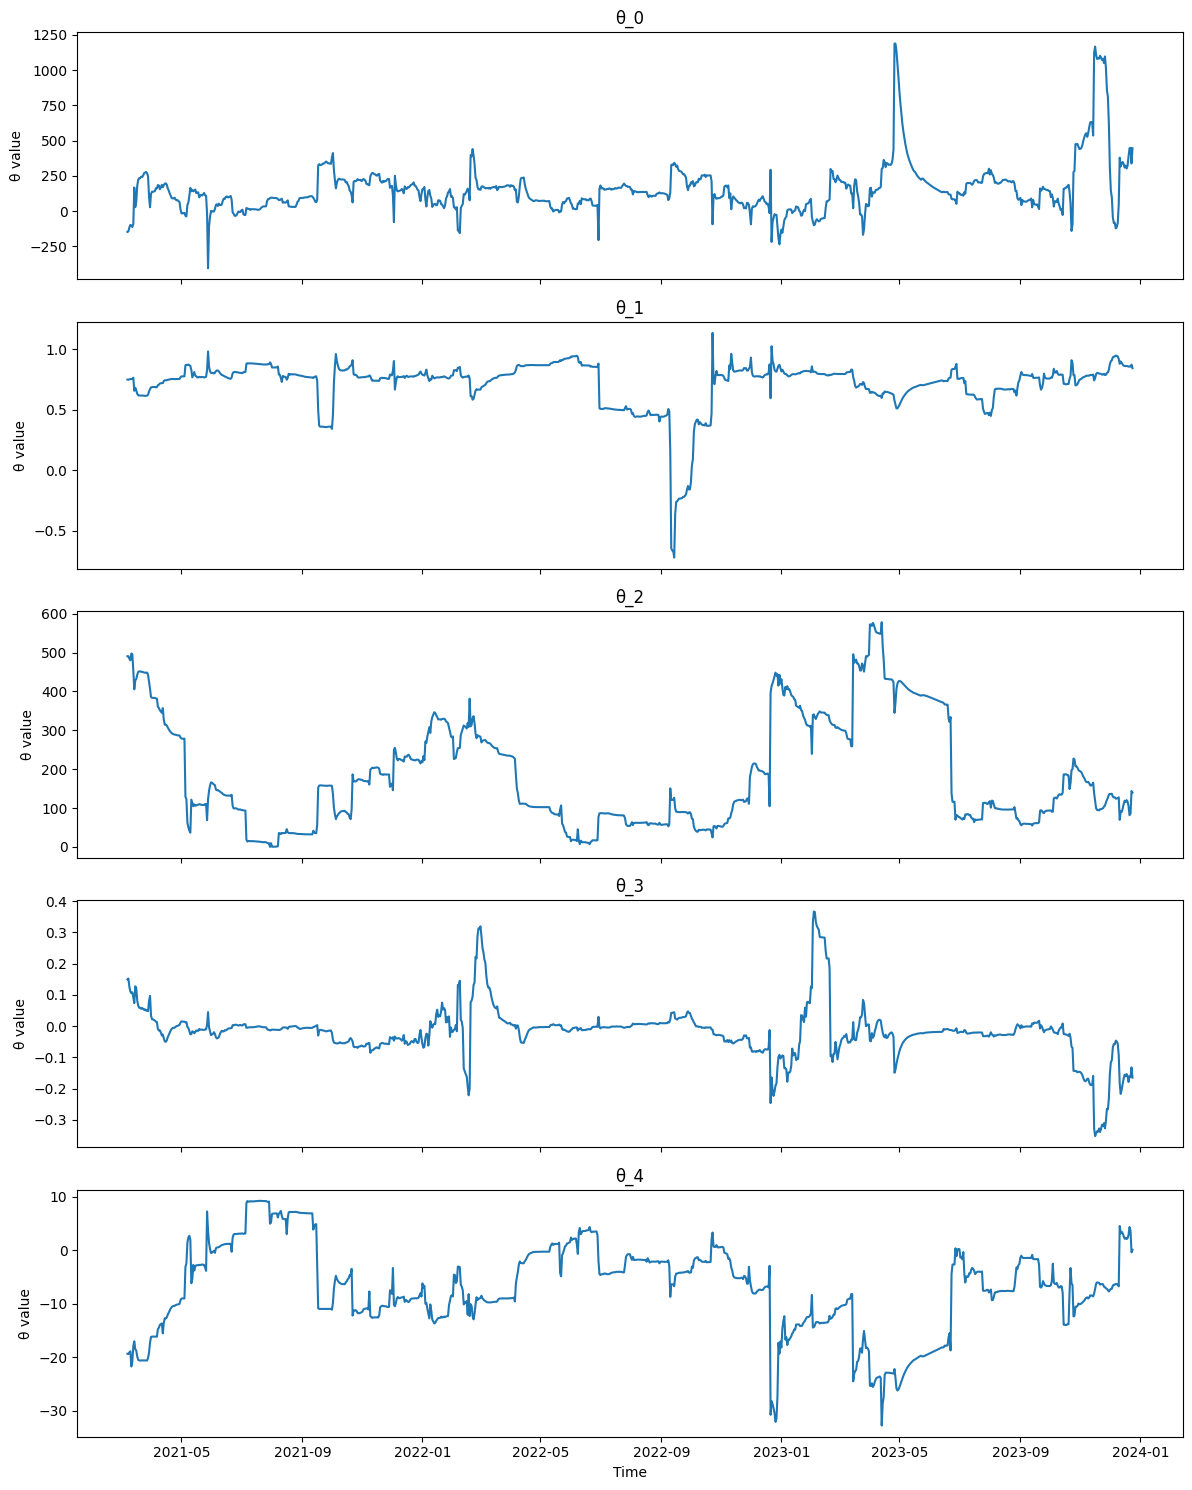

In [5]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# -------------------------------
# Helper Functions
# -------------------------------
def low_pass(series, a1):
    """Causal EWMA filter."""
    return series.ewm(alpha=1 - a1, adjust=False).mean().values

def score(residuals, mask=None):
    """Compute RMSE; if mask is given, only over mask."""
    if mask is not None:
        residuals = residuals[mask]
    return np.sqrt(np.nanmean(residuals**2))

def rls_initialize(n_params, delta=1000):
    """Initialize θ=0 and P=δ·I."""
    return np.zeros(n_params), delta * np.eye(n_params)

def rls_update(theta, P, x_t, y_t, lam):
    """One RLS update step."""
    xcol = x_t.reshape(-1,1)
    denom = lam + (xcol.T @ P @ xcol).item()
    K = (P @ xcol) / denom
    err = y_t - (xcol.T @ theta.reshape(-1,1)).item()
    theta = theta + (K.flatten() * err)
    P     = (P - K @ xcol.T @ P) / lam
    return theta, P

# -------------------------------
# Online RLS Forecast Function
# -------------------------------
def online_rls_k(df, lam, a1, delta, k, extra_features=None):
    """
    Online k-step-ahead RLS with baseline features
    [bias, y_{t-1}, precip_lp_{t+k-1}], plus any extra_features (shifted by k-1).
    Returns:
      yhat: pd.Series of forecasts
      theta_df: pd.DataFrame of θ at each timestamp
    """
    D = df.copy()
    D['time'] = pd.to_datetime(D['time'])
    D.set_index('time', inplace=True)

    y_arr = D['KarupBro'].values
    prec  = D['precip_total_daily'].values
    n = len(D)
    m = k - 1

    # baseline precip prediction
    prec_pred = np.full(n, np.nan)
    prec_pred[:n-m] = prec[m:]
    prec_lp = low_pass(pd.Series(prec_pred, index=D.index), a1)

    # lag-1 inflow
    y_lag1 = np.full(n, np.nan)
    y_lag1[1:] = y_arr[:-1]

    # extra feature predictions
    extra_preds = {}
    if extra_features:
        for f in extra_features:
            arr = D[f].values
            arr_pred = np.full(n, np.nan)
            arr_pred[:n-m] = arr[m:]
            if f == 'precip_total_daily':
                arr_pred = low_pass(pd.Series(arr_pred, index=D.index), a1)
            extra_preds[f] = arr_pred

    # initialize RLS
    n_params = 3 + (len(extra_features) if extra_features else 0)
    theta, P = rls_initialize(n_params, delta)

    yhat = np.full(n, np.nan)
    # <-- NEW: allocate history
    theta_hist = np.zeros((n, n_params))

    for t in range(m+1, n):
        x = [1.0, y_lag1[t], prec_lp[t]]
        if extra_features:
            for f in extra_features:
                x.append(extra_preds[f][t])
        x_t = np.array(x)

        yhat[t] = x_t @ theta            # predict
        theta_hist[t, :] = theta         # <-- RECORD θ before update

        if not np.isnan(y_arr[t]):        # update
            theta, P = rls_update(theta, P, x_t, y_arr[t], lam)

    # wrap into pandas
    theta_df = pd.DataFrame(
        theta_hist,
        index=D.index,
        columns=[f'θ_{i}' for i in range(n_params)]
    )

    return pd.Series(yhat, index=D.index), theta_df

# -------------------------------
# Forward Selection + Hyperparam Search on Training Data
# -------------------------------
def forward_sel_with_hyper(df_reset, candidates,
                           lam_grid, a1_grid, delta,
                           max_features=None, k=1):
    """
    Forward selection with hyperparam search,
    scoring RMSE on all train points.
    Returns selected features, best λ, best a₁, best train RMSE.
    """
    D = df_reset.copy()
    D['time'] = pd.to_datetime(D['time'])
    D.set_index('time', inplace=True)
    y_orig = D['KarupBro']

    selected = []
    best_rmse = np.inf
    best_lam  = None
    best_a1   = None
    remaining = list(candidates)

    step = 0
    while remaining and (max_features is None or len(selected) < max_features):
        trial_results = []
        for f in remaining:
            for lam, a1 in itertools.product(lam_grid, a1_grid):
                feats = selected + [f]
                yhat = online_rls_k(df_reset, lam, a1, delta, k, extra_features=feats)[0]
                rmse = score(yhat.values - y_orig.values)
                trial_results.append((rmse, f, lam, a1))
        trial_results.sort(key=lambda x: x[0])
        rmse_cand, feat_cand, lam_cand, a1_cand = trial_results[0]
        if rmse_cand < best_rmse:
            selected.append(feat_cand)
            best_rmse = rmse_cand
            best_lam   = lam_cand
            best_a1    = a1_cand
            remaining.remove(feat_cand)
            step += 1
            print(f"Step {step}: added '{feat_cand}' with λ={lam_cand}, a₁={a1_cand}, RMSE={best_rmse:.4f}")
        else:
            break

    return selected, best_lam, best_a1, best_rmse

# -------------------------------
# Main: Train/Test Split & Execution
# -------------------------------
if __name__ == "__main__":
    # Load & clean data
    data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
    D = pd.read_csv(data_path)
    D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
    D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = np.nan
    D['temp_mean_daily'].interpolate(inplace=True)
    D['precip_total_daily'].fillna(0, inplace=True)

    # Prepare full dataframe
    D['time'] = pd.to_datetime(D['time'])
    D.set_index('time', inplace=True)
    df_full = D.reset_index()

    # Split into train/test
    n_test = 1023
    df_train = df_full.iloc[:-n_test].reset_index(drop=True)
    df_test  = df_full.iloc[-n_test:].reset_index(drop=True)

    # Determine candidate features (exclude target and baseline precip)
    numeric = df_full.select_dtypes(include=[np.number]).columns.tolist()
    numeric.remove('KarupBro')
    numeric.remove('precip_total_daily')
    candidates = numeric

    # Hyperparameter grids
    lam_grid = [0.9, 0.95, 0.99]
    a1_grid  = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    # Forward selection + hyper tuning on TRAIN set
    selected, lam_opt, a1_opt, train_rmse = forward_sel_with_hyper(
        df_train, candidates, lam_grid, a1_grid, delta=1000, max_features=None, k=1
    )
    print("\nSelected features (train):", selected)
    print(f"Optimal λ={lam_opt}, a₁={a1_opt}, Train RMSE (all): {train_rmse:.4f}")

    # Online forecasting on FULL series with frozen model, capturing θ-history
    yhat_full, theta_full = online_rls_k(df_full, lam_opt, a1_opt, delta=1000, k=1, extra_features=selected)

    # Extract test forecasts and compute test RMSE (as before)…
    test_index = df_full['time'].iloc[-n_test:]
    y_test     = df_full['KarupBro'].iloc[-n_test:].values
    yhat_test  = yhat_full.loc[test_index].values
    test_rmse  = score(yhat_test - y_test)
    print(f"Test RMSE (last {n_test}): {test_rmse:.4f}")

    # --- slice out θ over test period ---
    theta_test = theta_full.loc[test_index]

    # Number of parameters
    n_params = theta_test.shape[1]

    # Create one subplot per θ
    fig, axes = plt.subplots(n_params, 1, figsize=(12, 3 * n_params), sharex=True)
    # If there's only one param, make axes iterable
    if n_params == 1:
        axes = [axes]

    for i, col in enumerate(theta_test.columns):
        ax = axes[i]
        ax.plot(theta_test.index, theta_test[col])
        ax.set_title(f'{col}')
        ax.set_ylabel('θ value')

    # Label only the bottom x‐axis
    axes[-1].set_xlabel('Time')

    plt.tight_layout()
    plt.show()




=== ARX(1) ===
Step 1: added 'radiation_global_daily' with λ=0.95, a₁=0.6, RMSE=583.3270
Step 2: added 'precip_duration_daily' with λ=0.95, a₁=0.5, RMSE=567.6092
Selected: ['radiation_global_daily', 'precip_duration_daily']
Optimal λ=0.95, a₁=0.5, Train RMSE=567.6092
Test RMSE (ARX(1)): 388.6450

=== ARX(2) ===
Step 1: added 'temp_soil_max_daily' with λ=0.99, a₁=0.5, RMSE=514.0347
Step 2: added 'temp_mean_daily' with λ=0.99, a₁=0.5, RMSE=508.7599
Step 3: added 'precip_duration_daily' with λ=0.99, a₁=0.5, RMSE=506.0341
Step 4: added 'wind_speed_daily' with λ=0.99, a₁=0.5, RMSE=505.0624
Selected: ['temp_soil_max_daily', 'temp_mean_daily', 'precip_duration_daily', 'wind_speed_daily']
Optimal λ=0.99, a₁=0.5, Train RMSE=505.0624
Test RMSE (ARX(2)): 377.0997

=== ARX(3) ===
Step 1: added 'temp_soil_mean_daily' with λ=0.99, a₁=0.5, RMSE=509.7600
Step 2: added 'temp_grass_mean_daily' with λ=0.99, a₁=0.5, RMSE=504.8711
Step 3: added 'wind_speed_daily' with λ=0.99, a₁=0.5, RMSE=503.5711
Step 4:

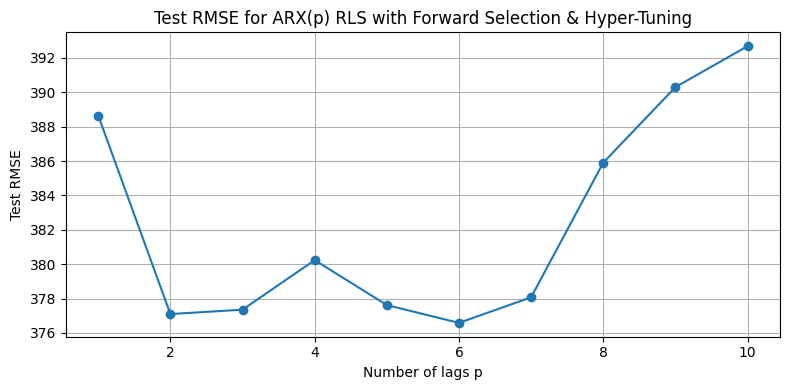

In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# -------------------------------
# Helper Functions
# -------------------------------
def low_pass(series, a1):
    """Causal EWMA filter."""
    return series.ewm(alpha=1 - a1, adjust=False).mean().values

def score(residuals, mask=None):
    """Compute RMSE; if mask is given, only over mask."""
    if mask is not None:
        residuals = residuals[mask]
    return np.sqrt(np.nanmean(residuals**2))

def rls_initialize(n_params, delta=1000):
    """Initialize θ=0 and P=δ·I."""
    return np.zeros(n_params), delta * np.eye(n_params)

def rls_update(theta, P, x_t, y_t, lam):
    """One RLS update step."""
    xcol = x_t.reshape(-1,1)
    denom = lam + (xcol.T @ P @ xcol).item()
    K = (P @ xcol) / denom
    err = y_t - (xcol.T @ theta.reshape(-1,1)).item()
    theta = theta + (K.flatten() * err)
    P     = (P - K @ xcol.T @ P) / lam
    return theta, P

# -------------------------------
# Online RLS Forecast Function (ARX(p))
# -------------------------------
def online_rls_k(df, lam, a1, delta, k, extra_features=None, lag_order=1):
    """
    Online k-step-ahead RLS with baseline features
    [bias, y_{t-1}...y_{t-p}, precip_lp_{t+k-1}], plus any extra_features shifted by k-1.
    """
    D = df.copy()
    D['time'] = pd.to_datetime(D['time'])
    D.set_index('time', inplace=True)

    y_arr = D['KarupBro'].values
    prec  = D['precip_total_daily'].values
    n = len(D)
    m = k - 1

    # one-step-ahead precip prediction + low-pass
    prec_pred = np.full(n, np.nan)
    prec_pred[:n-m] = prec[m:]
    prec_lp = low_pass(pd.Series(prec_pred, index=D.index), a1)

    # build lagged inflows y_{t-1}...y_{t-p}
    y_lags = np.full((n, lag_order), np.nan)
    for lag in range(1, lag_order+1):
        y_lags[lag:, lag-1] = y_arr[:-lag]

    # extra feature predictions
    extra_preds = {}
    if extra_features:
        for f in extra_features:
            arr = D[f].values
            arr_pred = np.full(n, np.nan)
            arr_pred[:n-m] = arr[m:]
            if f == 'precip_total_daily':
                arr_pred = low_pass(pd.Series(arr_pred, index=D.index), a1)
            extra_preds[f] = arr_pred

    # initialize RLS: bias + p lags + precip + extras
    n_params = 1 + lag_order + 1 + (len(extra_features) if extra_features else 0)
    theta, P = rls_initialize(n_params, delta)

    yhat = np.full(n, np.nan)
    for t in range(m + lag_order, n):
        x = [1.0] + y_lags[t].tolist() + [prec_lp[t]]
        if extra_features:
            for f in extra_features:
                x.append(extra_preds[f][t])
        x_t = np.array(x)

        # predict & update
        yhat[t] = x_t @ theta
        if not np.isnan(y_arr[t]):
            theta, P = rls_update(theta, P, x_t, y_arr[t], lam)

    return pd.Series(yhat, index=D.index)

# -------------------------------
# Forward Selection + Hyperparam Search
# -------------------------------
def forward_sel_with_hyper(df_reset, candidates,
                           lam_grid, a1_grid, delta,
                           max_features=None, k=1, lag_order=1):
    """
    Forward selection with hyperparam search,
    scoring RMSE on all train points.
    Returns selected features, best λ, best a₁, best train RMSE.
    """
    D = df_reset.copy()
    D['time'] = pd.to_datetime(D['time'])
    D.set_index('time', inplace=True)
    y_orig = D['KarupBro'].values

    selected = []
    best_rmse = np.inf
    best_lam  = None
    best_a1   = None
    remaining = list(candidates)
    step = 0

    while remaining and (max_features is None or len(selected) < max_features):
        trial_results = []
        for f in remaining:
            for lam, a1 in itertools.product(lam_grid, a1_grid):
                feats = selected + [f]
                yhat = online_rls_k(df_reset, lam, a1, delta, k,
                                    extra_features=feats,
                                    lag_order=lag_order)
                rmse = score(yhat.values - y_orig)
                trial_results.append((rmse, f, lam, a1))
        trial_results.sort(key=lambda x: x[0])
        rmse_cand, feat_cand, lam_cand, a1_cand = trial_results[0]
        if rmse_cand < best_rmse:
            selected.append(feat_cand)
            best_rmse = rmse_cand
            best_lam   = lam_cand
            best_a1    = a1_cand
            remaining.remove(feat_cand)
            step += 1
            print(f"Step {step}: added '{feat_cand}' with λ={lam_cand}, a₁={a1_cand}, RMSE={best_rmse:.4f}")
        else:
            break

    return selected, best_lam, best_a1, best_rmse

# -------------------------------
# Main: Loop over p = 1..10
# -------------------------------
if __name__ == "__main__":
    # Load & clean data
    data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
    D = pd.read_csv(data_path)
    D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
    D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = np.nan
    D['temp_mean_daily'].interpolate(inplace=True)
    D['precip_total_daily'].fillna(0, inplace=True)

    D['time'] = pd.to_datetime(D['time'])
    D.set_index('time', inplace=True)
    df_full = D.reset_index()

    # Train/test split
    n_test = 1023
    df_train = df_full.iloc[:-n_test].reset_index(drop=True)
    df_test  = df_full.iloc[-n_test:].reset_index(drop=True)
    test_times = df_test['time']

    # Candidate features
    numeric = df_full.select_dtypes(include=[np.number]).columns.tolist()
    numeric.remove('KarupBro')
    numeric.remove('precip_total_daily')

    # Hyperparameter grids
    lam_grid = [0.9, 0.95, 0.99]
    a1_grid  = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    delta = 1000
    k = 1  # one-step ahead

    lag_orders = range(1, 11)
    test_rmses = []

    for p in lag_orders:
        print(f"\n=== ARX({p}) ===")
        # Forward selection + hyper tuning on TRAIN
        selected, lam_opt, a1_opt, train_rmse = forward_sel_with_hyper(
            df_train, numeric, lam_grid, a1_grid, delta,
            max_features=None, k=k, lag_order=p
        )
        print(f"Selected: {selected}")
        print(f"Optimal λ={lam_opt}, a₁={a1_opt}, Train RMSE={train_rmse:.4f}")

        # Forecast on TEST
        yhat_full = online_rls_k(df_full, lam_opt, a1_opt, delta, k,
                                 extra_features=selected,
                                 lag_order=p)
        y_test = df_test['KarupBro'].values
        yhat_test = yhat_full.reindex(test_times).values
        rmse_test = score(yhat_test - y_test)
        print(f"Test RMSE (ARX({p})): {rmse_test:.4f}")
        test_rmses.append(rmse_test)

    # Plot Test RMSE vs. p
    plt.figure(figsize=(8, 4))
    plt.plot(list(lag_orders), test_rmses, marker='o', linewidth=1.5)
    plt.xlabel('Number of lags p')
    plt.ylabel('Test RMSE')
    plt.title('Test RMSE for ARX(p) RLS with Forward Selection & Hyper-Tuning')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Andet

Horizon 1:
  Persistence Forecast: {'NSE': 0.9275536370721981, 'KGE': 0.9635965465271273, 'FBAL': 0.9976806309993924, 'CSI': 0.7724137931034483}
  RLS Forecast: {'NSE': 0.9794489578365673, 'KGE': 0.9876543199367651, 'FBAL': 1.0023375421799543, 'CSI': 0.8832116788321168}
Horizon 2:
  Persistence Forecast: {'NSE': 0.8028515597062746, 'KGE': 0.900794813332926, 'FBAL': 0.9950181736265805, 'CSI': 0.6}
  RLS Forecast: {'NSE': 0.9629043741016678, 'KGE': 0.9776817984485456, 'FBAL': 0.9930007737588472, 'CSI': 0.8428571428571429}
Horizon 3:
  Persistence Forecast: {'NSE': 0.6786590472241305, 'KGE': 0.8376771052938984, 'FBAL': 0.9918324302573867, 'CSI': 0.48255813953488375}
  RLS Forecast: {'NSE': 0.9565889959691685, 'KGE': 0.9618838924287058, 'FBAL': 0.9862375053567578, 'CSI': 0.8333333333333334}
Horizon 4:
  Persistence Forecast: {'NSE': 0.5680852809702226, 'KGE': 0.7813790758517669, 'FBAL': 0.9891951106954043, 'CSI': 0.41899441340782123}
  RLS Forecast: {'NSE': 0.9555847911142026, 'KGE': 0.955

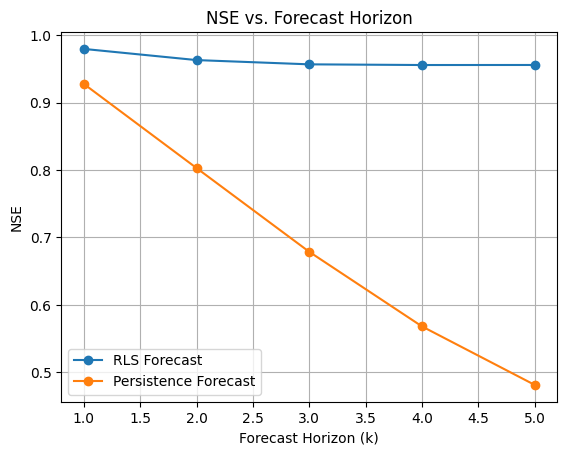

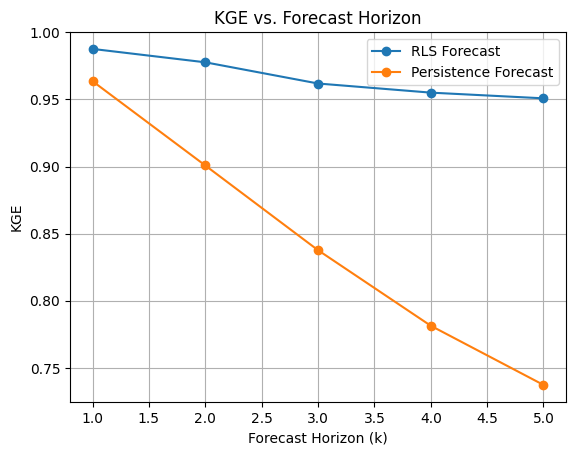

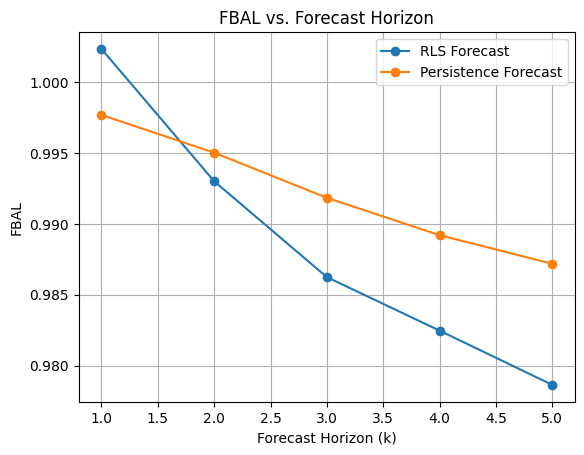

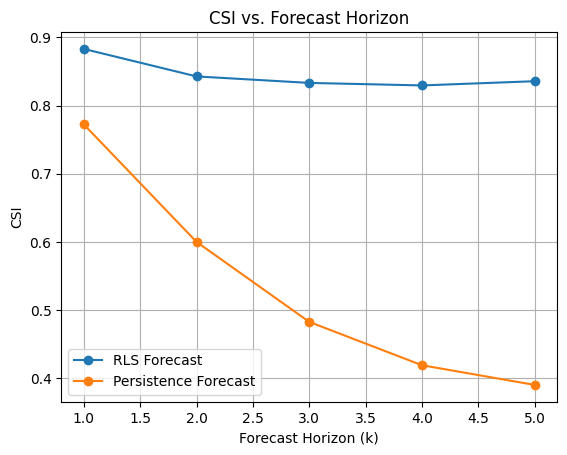

Done!


'\nForklaring om CSI:\n\n- CSI (Critical Success Index) måler hvor god en model er til at fange ekstreme hændelser korrekt.\n- CSI = TP / (TP + FP + FN)\n- Hvis CSI er tæt på 1, betyder det at modellen forudser ekstreme hændelser meget godt uden mange fejl.\n- Hvis CSI er tæt på 0, betyder det at modellen enten misser mange events eller laver mange falske alarmer.\n\nI denne kode er en ekstrem hændelse defineret som et flow i top 10% af historiske observationer (90%-percentilen).\n'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# -------------------------------
# Helper Functions
# -------------------------------

def low_pass(series, a1):
    return series.ewm(alpha=1 - a1, adjust=False).mean()

def persistence(df, horizons):
    forecasts = pd.DataFrame(index=df.index)
    for k in horizons:
        forecasts[f'k{k}'] = df['y'].shift(1)
    return forecasts

def nse(obs, sim):
    return 1 - np.sum((obs - sim)**2) / np.sum((obs - np.mean(obs))**2)

def kge(obs, sim):
    r, _ = pearsonr(obs, sim)
    beta = np.mean(sim) / np.mean(obs)
    gamma = np.std(sim) / np.std(obs)
    return 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)

def fbal(obs, sim):
    return np.sum(sim) / np.sum(obs)

def csi(obs, sim, threshold):
    tp = np.sum((obs >= threshold) & (sim >= threshold))
    fp = np.sum((obs < threshold) & (sim >= threshold))
    fn = np.sum((obs >= threshold) & (sim < threshold))
    if (tp + fp + fn) == 0:
        return np.nan
    return tp / (tp + fp + fn)

def calculate_metrics(obs, sim, threshold=10):
    mask = ~np.isnan(obs) & ~np.isnan(sim)
    obs_valid = obs[mask]
    sim_valid = sim[mask]
    return {
        'NSE': nse(obs_valid, sim_valid),
        'KGE': kge(obs_valid, sim_valid),
        'FBAL': fbal(obs_valid, sim_valid),
        'CSI': csi(obs_valid, sim_valid, threshold)
    }

def plot_metric(metric_dict, metric_name, horizons):
    plt.figure()
    for model_name, metrics in metric_dict.items():
        values = [metrics[f'k{k}'][metric_name] for k in horizons]
        plt.plot(horizons, values, marker='o', label=model_name)
    plt.xlabel("Forecast Horizon (k)")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} vs. Forecast Horizon")
    plt.legend()
    plt.grid(True)
    plt.show()

def rls_fit(X, y, lam=0.9, delta=1000):
    n_obs, n_params = X.shape
    theta = np.zeros(n_params)
    P = delta * np.eye(n_params)
    yhat = np.empty(n_obs)
    yhat[:] = np.nan
    for t in range(n_obs):
        x_t = X[t, :].reshape(-1, 1)
        if np.any(np.isnan(x_t)):
            continue
        denom = lam + (x_t.T @ P @ x_t)[0, 0]
        K = (P @ x_t) / denom
        if np.isnan(y[t]):
            continue
        error = y[t] - (x_t.T @ theta.reshape(-1, 1))[0, 0]
        theta = theta + (K.flatten() * error)
        P = (P - K @ x_t.T @ P) / lam
        yhat[t] = (X[t, :] @ theta)
    return theta, yhat

def fit_rls_forecast(df, lam=0.9, a1=0.9, horizons=[1,2,3,4,5]):
    forecasts = pd.DataFrame(index=df.index)
    coeffs = {}
    for k in horizons:
        bias = pd.Series(1, index=df.index, name='bias')
        inflow_pred = df['y'].shift(1).rename('inflow')
        temp_pred = df['temp_mean_daily'].shift(-(k-1)).rename('temp')
        precip_pred = df['precip_total_daily'].shift(-(k-1))
        precip_pred_lp = low_pass(precip_pred, a1).rename('precip')
        X = pd.concat([bias, inflow_pred, temp_pred, precip_pred_lp], axis=1)
        y_target = df['y'].shift(-(k-1))
        valid = X.notna().all(axis=1) & y_target.notna()
        X_valid = X.loc[valid].to_numpy()
        y_valid = y_target.loc[valid].to_numpy()
        theta, yhat = rls_fit(X_valid, y_valid, lam=lam, delta=1000)
        coeffs[f'k{k}'] = theta
        yhat_full = pd.Series(data=np.nan, index=df.index)
        yhat_full.loc[valid] = yhat
        forecasts[f'k{k}'] = yhat_full
    return coeffs, forecasts

# -------------------------------
# Main Script
# -------------------------------

data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv"
D = pd.read_csv(data_path)

D['t'] = pd.to_datetime(D['time'])
D['y'] = D['KarupBro']

D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = D['temp_mean_daily'].shift(1)
D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = 0

horizons = [1, 2, 3, 4, 5]

D_time_indexed = D.set_index('t')

scoreperiod = D_time_indexed.index[-1023:]

coeffs, Yhat1 = fit_rls_forecast(D, lam=0.9, a1=0.9, horizons=horizons)
Yhat1.index = D_time_indexed.index

YhatP = persistence(D_time_indexed, horizons)

threshold_value = np.percentile(D_time_indexed['y'], 90)

metrics_YhatP = {}
metrics_Yhat1 = {}

for k in horizons:
    target = D_time_indexed['y'].shift(-(k-1))
    forecast_persistence = YhatP[f'k{k}']
    forecast_rls = Yhat1[f'k{k}']
    mask = D_time_indexed.index.isin(scoreperiod)

    metrics_YhatP[f'k{k}'] = calculate_metrics(target[mask], forecast_persistence[mask], threshold=threshold_value)
    metrics_Yhat1[f'k{k}'] = calculate_metrics(target[mask], forecast_rls[mask], threshold=threshold_value)

for k in horizons:
    print(f"Horizon {k}:")
    print("  Persistence Forecast:", metrics_YhatP[f'k{k}'])
    print("  RLS Forecast:", metrics_Yhat1[f'k{k}'])

plot_metric({'RLS Forecast': metrics_Yhat1, 'Persistence Forecast': metrics_YhatP}, 'NSE', horizons)
plot_metric({'RLS Forecast': metrics_Yhat1, 'Persistence Forecast': metrics_YhatP}, 'KGE', horizons)
plot_metric({'RLS Forecast': metrics_Yhat1, 'Persistence Forecast': metrics_YhatP}, 'FBAL', horizons)
plot_metric({'RLS Forecast': metrics_Yhat1, 'Persistence Forecast': metrics_YhatP}, 'CSI', horizons)

print("Done!")

"""
Forklaring om CSI:

- CSI (Critical Success Index) måler hvor god en model er til at fange ekstreme hændelser korrekt.
- CSI = TP / (TP + FP + FN)
- Hvis CSI er tæt på 1, betyder det at modellen forudser ekstreme hændelser meget godt uden mange fejl.
- Hvis CSI er tæt på 0, betyder det at modellen enten misser mange events eller laver mange falske alarmer.

I denne kode er en ekstrem hændelse defineret som et flow i top 10% af historiske observationer (90%-percentilen).
"""

## Stationaritet